# Setup

### Import necessary modules and do some basic setup.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# TensorFlow ≥2.0 is required
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import tensorflow as tf
assert tf.__version__ >= '2.0'

from tensorflow import keras
from tensorflow.keras import layers

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Common imports
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import dask
import time
import math
import imageio
import PIL
dask.config.set({'array.slicing.split_large_chunks': False})

from IPython import display

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Custom utils
from utils.utils_data import *
from utils.utils_ml import *
from utils.utils_plot import *

Num GPUs Available:  1


### Define some paths and constants.

In [2]:
# Paths
DATADIR = os.path.join(os.getcwd(), '..', 'data')

# Some constants
DATE_START = '1979-01-01'
DATE_END = '2020-12-31'
YY_TRAIN = [1979, 2015]
YY_TEST = [2016, 2020]

# Use standardization
DO_STANDARDIZE = False

In [3]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis_r = cm.get_cmap('viridis_r', 256)
newcolors = viridis_r(np.linspace(0, 1, 256))
pink = np.array([200/256, 200/256, 200/256, 1])
newcolors[:1, :] = pink
newcmp = ListedColormap(newcolors)

### Define some functions.

In [4]:
# Rescale image
def rescale_img(img_data, nan_mask=[], std=[], mean=[]):
    img = np.copy(img_data)
    if DO_STANDARDIZE:
        img *= std
        img += mean
    img[nan_mask] = np.nan
    img[img<0.1] = 0
    
    return img


# Plot samples of original vs reconstructed
def plot_sample(data_idx, original, std, mean, decoded_imgs):

    n_days = len(data_idx)
    n_models = len(decoded_imgs)
    
    plt.figure(figsize=(18, 2*(n_models + 1)))
    for i_day, day in enumerate(data_idx):
        img_orig = rescale_img(original[day,:,:], nan_mask=nan_mask, std=std, mean=mean)
        vmin = np.nanmin(img_orig)
        vmax = np.nanmax(img_orig)
        img_preds = []
        for i_mod in range(n_models):
            img_pred = rescale_img(decoded_imgs[i_mod][day,:,:], nan_mask=nan_mask, std=std, mean=mean)
            vmin = min(vmin, np.nanmin(img_pred))
            vmax = max(vmax, np.nanmax(img_pred))
            img_preds.append(img_pred)

        # display original
        ax = plt.subplot(n_models + 1, n_days, i_day + 1)
        plt.imshow(img_orig, cmap=newcmp, vmin=vmin, vmax=vmax)
        plt.title("original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.colorbar()
        plt.axis('off')

        # display reconstructions
        for i_mod, model in enumerate(img_preds):
            ax = plt.subplot(n_models + 1, n_days, i_day + 1 + (i_mod + 1)*n_days)
            plt.imshow(model, cmap=newcmp, vmin=vmin, vmax=vmax)
            plt.title(f"reconstructed cae v{i_mod + 1}")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.colorbar()
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    


# Merging 2d matrix of images in 1 image (from CAS AML course)
def mosaic(mtr_of_ims):
    ny = len(mtr_of_ims)
    assert(ny != 0)

    nx = len(mtr_of_ims[0])
    assert(nx != 0)

    im_sh = mtr_of_ims[0][0].shape

    assert (2 <= len(im_sh) <= 3)
    multichannel = len(im_sh) == 3

    if multichannel:
        h, w, c = im_sh
    else:
        h, w = im_sh

    h_c = h * ny + 1 * (ny-1)
    w_c = w * nx + 1 * (nx-1)

    canv_sh = (h_c, w_c, c) if multichannel else (h_c, w_c)
    canvas = np.ones(shape=canv_sh, dtype=np.float32)*0.5

    for iy, row in enumerate(mtr_of_ims):
        y_ofs = iy * (h + 1)
        for ix, im in enumerate(row):
            x_ofs = ix * (w + 1)
            canvas[y_ofs:y_ofs + h, x_ofs:x_ofs + w] = im

    return canvas

# Preparing precipitation data

RhiresD daily gridded dataset (MeteoSwiss)

<span><img src="images/RhiresD.png" alt="RhiresD" width="500"/></span>

### Load, split and normalize data

In [5]:
# Load original gridded data
prec = xr.open_dataset(DATADIR + '/MeteoSwiss/RhiresD_ch02.lonlat_19790101_20210731.nc')
prec = prec.sel(time=slice(DATE_START, DATE_END))

In [6]:
# Split set into (training + validation) and testing based on dates
prec_train_full = prec.sel(time=slice('{}-01-01'.format(YY_TRAIN[0]), '{}-12-31'.format(YY_TRAIN[1])))
prec_test = prec.sel(time=slice('{}-01-01'.format(YY_TEST[0]), '{}-12-31'.format(YY_TEST[1])))

In [7]:
# Transform to numpy arrays
X_train_full = prec_train_full.RhiresD.to_numpy()
X_test = prec_test.RhiresD.to_numpy()

X_train_full.shape

(13514, 103, 241)

In [8]:
# Flip latitude axis
X_train_full = np.flip(X_train_full, axis=1)
X_test = np.flip(X_test, axis=1)

In [9]:
# Crop to ease use in CNN
X_train_full = X_train_full[:, 0:100, 0:240]
X_test = X_test[:, 0:100, 0:240]

X_train_full.shape

(13514, 100, 240)

In [10]:
# Value/nan mask 
nan_mask = np.isnan(X_train_full[0,:,:])

In [11]:
# Split full training into training and validation sets (and shuffle)
X_train, X_valid = train_test_split(X_train_full, test_size=0.25, random_state=42)

In [12]:
print(f'Minimum value of the train period: {np.nanmin(X_train)}; maximum: {np.nanmax(X_train):.1f}')
print(f'Minimum value of the validation period: {np.nanmin(X_valid)}; maximum: {np.nanmax(X_valid):.1f}')
print(f'Minimum value of the test period: {np.nanmin(X_test)}; maximum: {np.nanmax(X_test):.1f}')

Minimum value of the train period: 0.0; maximum: 397.8
Minimum value of the validation period: 0.0; maximum: 443.0
Minimum value of the test period: 0.0; maximum: 417.9


In [13]:
# Standarize data
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
if DO_STANDARDIZE:
    X_train = (X_train - X_mean) / X_std
    X_valid = (X_valid - X_mean) / X_std
    X_test = (X_test - X_mean) / X_std


In [14]:
print(f'Minimum value of the train period: {np.nanmin(X_train)}; maximum: {np.nanmax(X_train):.1f}')
print(f'Minimum value of the validation period: {np.nanmin(X_valid)}; maximum: {np.nanmax(X_valid):.1f}')
print(f'Minimum value of the test period: {np.nanmin(X_test)}; maximum: {np.nanmax(X_test):.1f}')

Minimum value of the train period: 0.0; maximum: 397.8
Minimum value of the validation period: 0.0; maximum: 443.0
Minimum value of the test period: 0.0; maximum: 417.9


In [15]:
# Replace nans with 0s
X_train = np.nan_to_num(X_train)
X_valid = np.nan_to_num(X_valid)
X_test = np.nan_to_num(X_test)

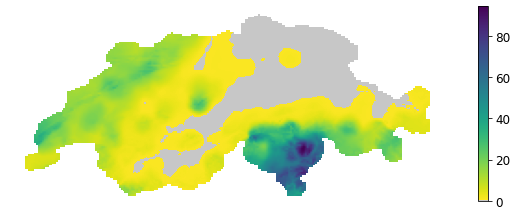

In [16]:
plt.figure(figsize=(8, 3))
img = rescale_img(X_train[100,:,:], nan_mask=nan_mask, std=X_std, mean=X_mean)
plt.imshow(img, cmap=newcmp)
plt.axis('off')
plt.tight_layout()
plt.colorbar()


Text(0.5, 1.0, 'Std of precipitation')

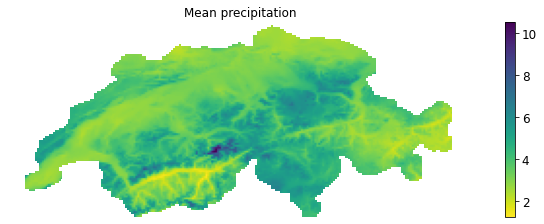

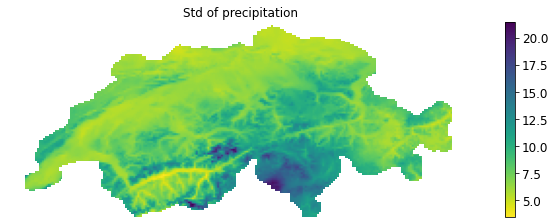

In [17]:
plt.figure(figsize=(9, 3))
plt.imshow(X_mean)
plt.axis('off')
plt.tight_layout()
plt.set_cmap('viridis_r')
plt.colorbar()
plt.title('Mean precipitation')

plt.figure(figsize=(9, 3))
plt.imshow(X_std)
plt.axis('off')
plt.tight_layout()
plt.set_cmap('viridis_r')
plt.colorbar()
plt.title('Std of precipitation')

# Convolutional Autoencoder

### Define the model

In [18]:
class CAE(tf.keras.Model):
    """Convolutional autoencoder."""

    def __init__(self, data_size, latent_dim=2, architecture=1):
        super(CAE, self).__init__()
        self.data_size = list(data_size)
        self.latent_dim = latent_dim
        self.preflat_shape = 1

        if architecture == 1:
            self.create_v1()
        elif architecture == 2:
            self.create_v2()
        else:
            raise('The architecture was not correctly defined')
            self.create_v1()
            
        self.crop_output()
        
        
    def create_v1(self):
        self.encoder = tf.keras.Sequential(
            [
                layers.InputLayer(input_shape=self.data_size),
                layers.Reshape(target_shape = self.data_size+[1]),
                layers.Conv2D(32, 3, strides=(2, 2), padding='same', activation='relu'),
                layers.Conv2D(64, 3, strides=(2, 2), padding='same', activation='relu'),
                layers.Flatten(),
                layers.Dense(self.latent_dim, activation='sigmoid'),
            ]
        )

        self.preflat_shape = self.encoder.layers[-2].input.get_shape().as_list()[1:]
        
        print(self.preflat_shape)

        self.decoder = tf.keras.Sequential(
            [
                layers.InputLayer(input_shape=(self.latent_dim,)),
                layers.Dense(np.prod(self.preflat_shape), activation='relu'),
                layers.Reshape(target_shape=self.preflat_shape),
                layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
                layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),
                layers.Conv2DTranspose(1, 3, strides=1, padding='same'),
            ]
        )

        
    def create_v2(self):
        self.encoder = tf.keras.Sequential(
            [
                layers.InputLayer(input_shape=self.data_size),
                layers.Reshape(target_shape = self.data_size+[1]),
                layers.Conv2D(8, 3, padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2D(8, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2D(16, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2D(16, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2D(32, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2D(32, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2D(64, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Flatten(),
                layers.Dense(self.latent_dim, activation='sigmoid', kernel_initializer='he_normal')
            ]
        )
        
        self.preflat_shape = self.encoder.layers[-2].input.get_shape().as_list()[1:]

        self.decoder = tf.keras.Sequential(
            [
                layers.InputLayer(input_shape=(self.latent_dim,)),
                layers.Dense(np.prod(self.preflat_shape), activation='relu', kernel_initializer='he_normal'),
                layers.Reshape(target_shape=self.preflat_shape),
                layers.Conv2DTranspose(32, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2DTranspose(32, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2DTranspose(16, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2DTranspose(16, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2DTranspose(16, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2DTranspose(8, 3, strides=(2,2), padding='same', activation='relu', kernel_initializer='he_normal'),
                layers.Conv2D(1, 3, strides=(1,1), padding='same', activation='relu', kernel_initializer='he_normal')
            ]
        )
        
        
    def crop_output(self):
        
        h, w = self.decoder.layers[-1].output.get_shape().as_list()[1:3]  # reconstructed width and hight
        h_tgt, w_tgt = self.data_size[:2]
        dh = h - h_tgt  # deltas to be cropped away
        dw = w - w_tgt

        # add to decoder cropping layer and final reshaping
        self.decoder.add(layers.Cropping2D(cropping=((dh//2, dh-dh//2), (dw//2, dw-dw//2))))
        self.decoder.add(layers.Reshape(target_shape=self.data_size,))

        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    
    def encode(self, x):
        return self.encoder(x)

    
    def decode(self, z):
        return self.decoder(z)


In [19]:
# Clear session and set tf seed
keras.backend.clear_session()
tf.random.set_seed(42)

# Build and train the model
cae_1 = CAE(X_train.shape[1:3], latent_dim=2, architecture=1)
cae_1.compile(optimizer='adam', loss='mse')
history = cae_1.fit(X_test, X_test, epochs=50, shuffle=True, validation_data=(X_valid, X_valid))

2021-12-14 10:09:09.941381: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-14 10:09:10.689864: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10411 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:06:00.0, compute capability: 6.1


ListWrapper([25, 60, 64])
Epoch 1/50


2021-12-14 10:09:12.706446: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


58/58 [==============================] - 7s 71ms/step - loss: 37.2016 - val_loss: 27.6449
Epoch 2/50
58/58 [==============================] - 3s 54ms/step - loss: 22.7455 - val_loss: 22.7406
Epoch 3/50
58/58 [==============================] - 3s 55ms/step - loss: 20.4219 - val_loss: 20.3980
Epoch 4/50
58/58 [==============================] - 3s 55ms/step - loss: 18.1300 - val_loss: 19.1095
Epoch 5/50
58/58 [==============================] - 3s 55ms/step - loss: 17.7413 - val_loss: 18.1771
Epoch 6/50
58/58 [==============================] - 3s 55ms/step - loss: 16.7925 - val_loss: 16.1360
Epoch 7/50
58/58 [==============================] - 3s 55ms/step - loss: 14.2737 - val_loss: 15.2662
Epoch 8/50
58/58 [==============================] - 3s 55ms/step - loss: 13.4691 - val_loss: 13.8185
Epoch 9/50
58/58 [==============================] - 3s 55ms/step - loss: 12.8471 - val_loss: 14.0004
Epoch 10/50
58/58 [==============================] - 3s 54ms/step - loss: 12.6060 - val_loss: 13.3650


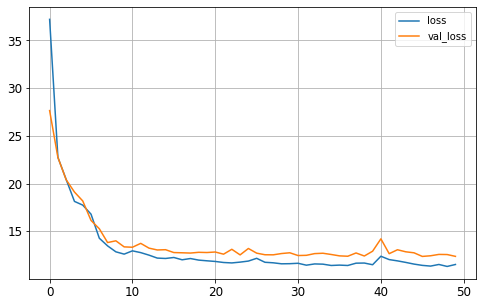

In [20]:
# Plot training evolution
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [21]:
# Clear session and set tf seed
keras.backend.clear_session()
tf.random.set_seed(42)

# Build and train the model
cae_2 = CAE(X_train.shape[1:3], latent_dim=2, architecture=2)
cae_2.compile(optimizer='adam', loss='mse')
history = cae_2.fit(X_test, X_test, epochs=50, shuffle=True, validation_data=(X_valid, X_valid))

Epoch 1/50
58/58 [==============================] - 4s 55ms/step - loss: 36.5827 - val_loss: 32.3137
Epoch 2/50
58/58 [==============================] - 2s 37ms/step - loss: 26.8157 - val_loss: 27.8690
Epoch 3/50
58/58 [==============================] - 2s 37ms/step - loss: 23.2612 - val_loss: 22.8054
Epoch 4/50
58/58 [==============================] - 2s 38ms/step - loss: 20.3533 - val_loss: 20.7496
Epoch 5/50
58/58 [==============================] - 2s 38ms/step - loss: 18.9685 - val_loss: 18.3646
Epoch 6/50
58/58 [==============================] - 2s 38ms/step - loss: 16.8608 - val_loss: 16.8018
Epoch 7/50
58/58 [==============================] - 2s 38ms/step - loss: 15.0244 - val_loss: 16.1161
Epoch 8/50
58/58 [==============================] - 2s 38ms/step - loss: 14.9390 - val_loss: 15.5978
Epoch 9/50
58/58 [==============================] - 2s 38ms/step - loss: 14.3565 - val_loss: 15.0076
Epoch 10/50
58/58 [==============================] - 2s 39ms/step - loss: 13.8968 - val_los

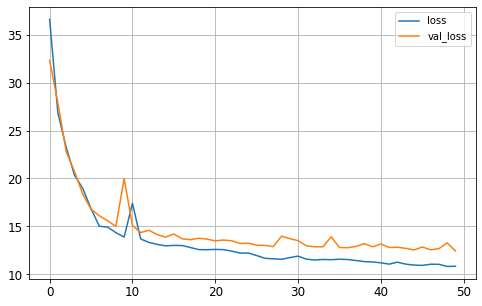

In [22]:
# Plot training evolution
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [23]:
encoded_imgs_cae_1 = cae_1.encoder(X_test[0:300, :, :]).numpy()
decoded_imgs_cae_1 = cae_1.decoder(encoded_imgs_cae_1).numpy()
encoded_imgs_cae_2 = cae_2.encoder(X_test[0:300, :, :]).numpy()
decoded_imgs_cae_2 = cae_2.decoder(encoded_imgs_cae_2).numpy()

Text(0.5, 1.0, 'Encoded images of CAE 2')

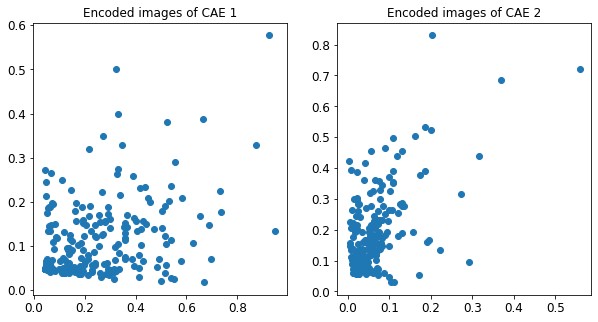

In [24]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=[10,5])
ax1.scatter(encoded_imgs_cae_1[:,0], encoded_imgs_cae_1[:,1])
ax1.set_title('Encoded images of CAE 1')
ax2.scatter(encoded_imgs_cae_2[:,0], encoded_imgs_cae_2[:,1])
ax2.set_title('Encoded images of CAE 2')

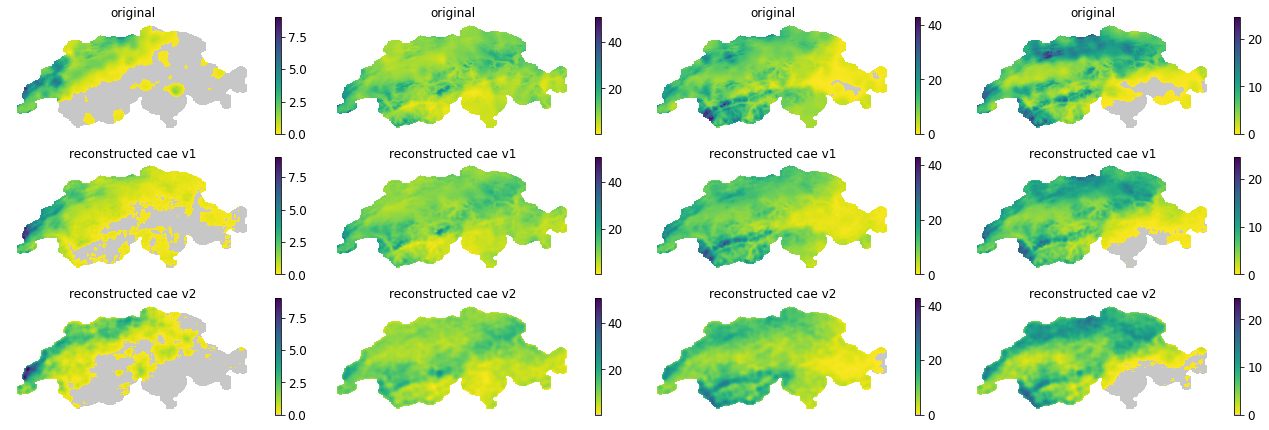

In [35]:
plot_sample(range(4), X_test, X_std, X_mean, [decoded_imgs_cae_1, decoded_imgs_cae_2])


In [26]:
n_img_axis = 10

scale = 1

zs = np.meshgrid(np.linspace(0, scale, n_img_axis),
                 np.linspace(0, scale, n_img_axis))
zs = np.stack(zs, axis=-1).reshape((-1, 2))
print(zs.shape)

(100, 2)


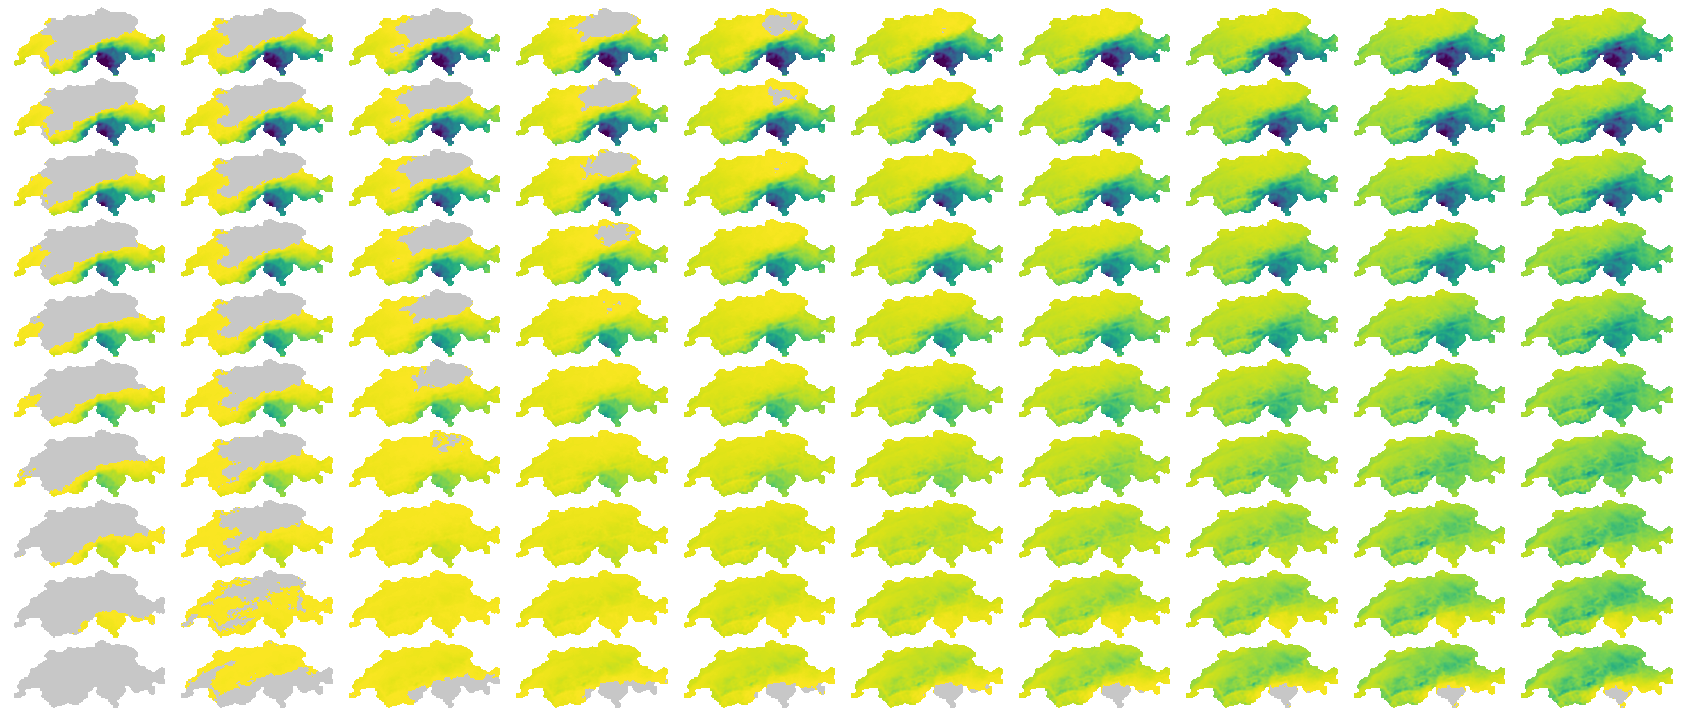

In [27]:
ims = cae_1.decode(zs.reshape((-1, 2))).numpy()
for i_img in range(len(ims)):
    ims[i_img] = rescale_img(ims[i_img], nan_mask=nan_mask, std=X_std, mean=X_mean)
sh = list(ims.shape)
ims = ims.reshape([n_img_axis, n_img_axis]+sh[1:])
plt.figure(figsize=(30, 30))
plt.imshow(mosaic(ims[::-1]), cmap=newcmp, vmin=0, vmax=200)
plt.axis('off')
plt.show()


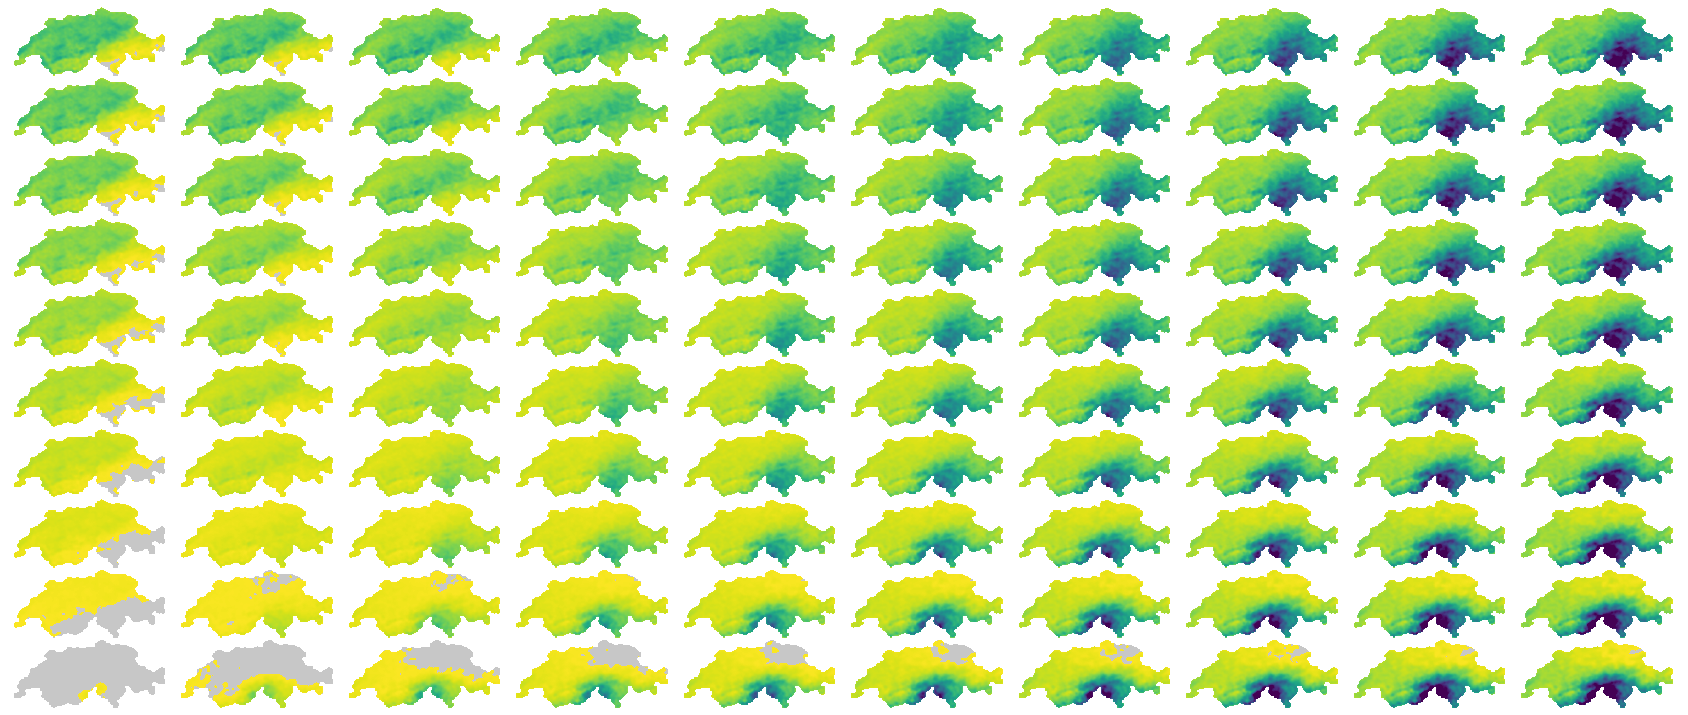

In [28]:
ims = cae_2.decode(zs.reshape((-1, 2))).numpy()
for i_img in range(len(ims)):
    ims[i_img] = rescale_img(ims[i_img], nan_mask=nan_mask, std=X_std, mean=X_mean)
sh = list(ims.shape)
ims = ims.reshape([n_img_axis, n_img_axis]+sh[1:])
plt.figure(figsize=(30, 30))
plt.imshow(mosaic(ims[::-1]), cmap=newcmp, vmin=0, vmax=200)
plt.axis('off')
plt.show()


In [29]:
# Clear session and set tf seed
keras.backend.clear_session()
tf.random.set_seed(42)

# Build and train the model
cae_1 = CAE(X_train.shape[1:3], latent_dim=64, architecture=1)
cae_1.compile(optimizer='adam', loss='mse')
history = cae_1.fit(X_test, X_test, epochs=50, shuffle=True, validation_data=(X_valid, X_valid))

ListWrapper([25, 60, 64])
Epoch 1/50
58/58 [==============================] - 5s 71ms/step - loss: 29.6038 - val_loss: 20.7270
Epoch 2/50
58/58 [==============================] - 3s 56ms/step - loss: 14.9176 - val_loss: 14.6449
Epoch 3/50
58/58 [==============================] - 3s 57ms/step - loss: 13.1466 - val_loss: 15.1952
Epoch 4/50
58/58 [==============================] - 3s 57ms/step - loss: 13.0728 - val_loss: 12.2794
Epoch 5/50
58/58 [==============================] - 3s 57ms/step - loss: 11.4288 - val_loss: 11.9635
Epoch 6/50
58/58 [==============================] - 3s 56ms/step - loss: 12.0954 - val_loss: 13.1134
Epoch 7/50
58/58 [==============================] - 3s 57ms/step - loss: 11.9085 - val_loss: 12.0165
Epoch 8/50
58/58 [==============================] - 3s 56ms/step - loss: 11.1948 - val_loss: 11.3741
Epoch 9/50
58/58 [==============================] - 3s 58ms/step - loss: 10.4266 - val_loss: 11.0511
Epoch 10/50
58/58 [==============================] - 3s 57ms/step

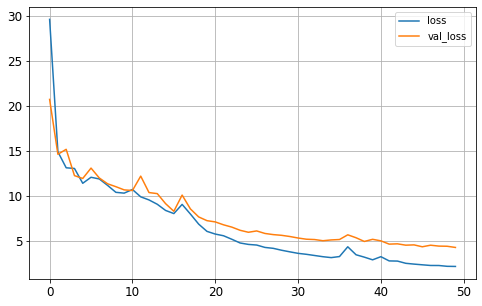

In [30]:
# Plot training evolution
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [31]:
# Clear session and set tf seed
keras.backend.clear_session()
tf.random.set_seed(42)

# Build and train the model
cae_2 = CAE(X_train.shape[1:3], latent_dim=64, architecture=2)
cae_2.compile(optimizer='adam', loss='mse')
history = cae_2.fit(X_test, X_test, epochs=50, shuffle=True, validation_data=(X_valid, X_valid))

Epoch 1/50
58/58 [==============================] - 4s 52ms/step - loss: 35.4841 - val_loss: 26.6678
Epoch 2/50
58/58 [==============================] - 2s 38ms/step - loss: 19.4619 - val_loss: 17.7647
Epoch 3/50
58/58 [==============================] - 2s 36ms/step - loss: 14.4468 - val_loss: 14.7332
Epoch 4/50
58/58 [==============================] - 2s 39ms/step - loss: 13.3566 - val_loss: 13.3905
Epoch 5/50
58/58 [==============================] - 2s 37ms/step - loss: 11.8211 - val_loss: 11.6580
Epoch 6/50
58/58 [==============================] - 2s 39ms/step - loss: 10.4651 - val_loss: 10.8578
Epoch 7/50
58/58 [==============================] - 2s 36ms/step - loss: 9.2555 - val_loss: 10.2989
Epoch 8/50
58/58 [==============================] - 2s 39ms/step - loss: 8.4633 - val_loss: 9.2859
Epoch 9/50
58/58 [==============================] - 2s 37ms/step - loss: 7.8682 - val_loss: 9.2739
Epoch 10/50
58/58 [==============================] - 2s 39ms/step - loss: 7.4776 - val_loss: 9.5

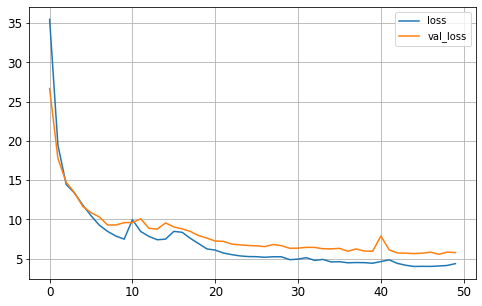

In [32]:
# Plot training evolution
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [33]:
encoded_imgs_cae_1 = cae_1.encoder(X_test[0:300, :, :]).numpy()
decoded_imgs_cae_1 = cae_1.decoder(encoded_imgs_cae_1).numpy()
encoded_imgs_cae_2 = cae_2.encoder(X_test[0:300, :, :]).numpy()
decoded_imgs_cae_2 = cae_2.decoder(encoded_imgs_cae_2).numpy()

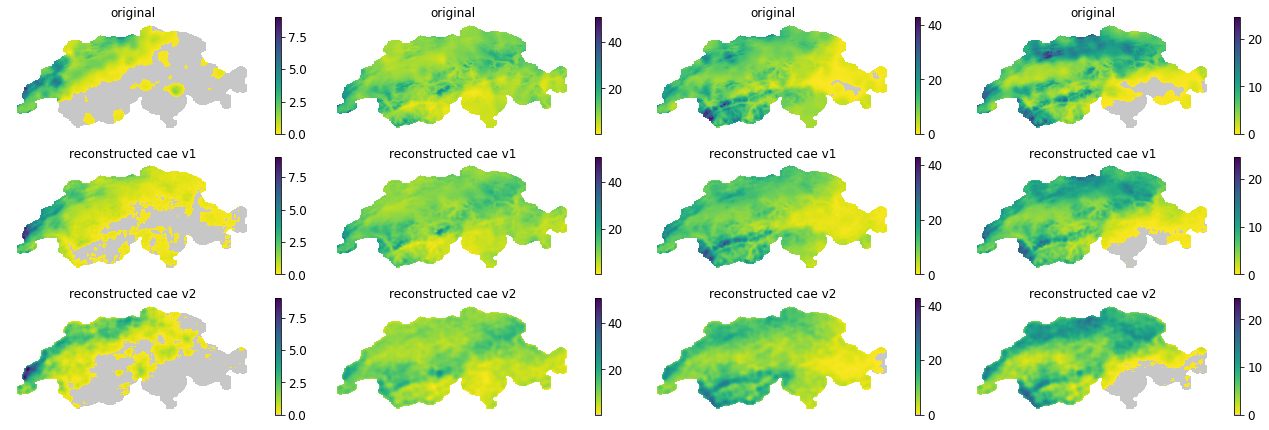

In [34]:
plot_sample(range(4), X_test, X_std, X_mean, [decoded_imgs_cae_1, decoded_imgs_cae_2])
